In [2]:
# Import modules
import os,glob
import numpy as np
import matplotlib
# For interactive jupyter lab notebook plots:
#%matplotlib ipympl
# Simple inline with no plot interaction
#%matplotlib inline
# For exporting and standalone graphics
#matplotlib.use('Tkagg')
try:
    import ipymplss
    %matplotlib ipympl
except ImportError:
    print('The ipympl is not installed. Figures will not be interactive')
    choice = input('Standalone or inline? [standalone | inline]')
    if choice == "inline":
        %matplotlib inline
    else:
        %matplotlib qt

from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'serif'

# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
def fix_canvas(current_fig):
    if 'ipympl' in matplotlib.get_backend(): 
        current_fig.canvas.layout.width = '{:}in'.format(current_fig.get_figwidth())
        current_fig.canvas.layout.height= '{:}in'.format(current_fig.get_figheight())
        
from astropy.io import fits
from astropy.wcs import WCS

The ipympl is not installed. Figures will not be interactive


Standalone or inline? [standalone | inline] inline


In [11]:
# Load data image data and print some basic data

# N2337
url = 'https://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_13442_95_acs_wfc_f814w&filename=hst_13442_95_acs_wfc_f814w_drz.fits'

# DW13
url = 'http://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_10608_05_acs_sbc_f150lp&filename=hst_10608_05_acs_sbc_f150lp_drz.fits'
    
# N2337
url = 'NGC-2337_ACS_WFC_F814W_adrz.fits'

# Use the image faile name as a root name for the files to be saved
if '/' in url:
    filename = url[url.rfind('/')+1:url.rfind('.fits')]
elif 'hla.stsci' in url:
    filename = url[url.rfind('=')+1:url.rfind('.fits')]
else:
    filename = url[:url.rfind('.fits')]

if 'data' in locals() or 'data' in globals(): del data,data_hdr,wcs

hdu = fits.open(url)
wcs = WCS(hdu[1].header)
data = fits.getdata(url) # hdu[0].data
data_hdr = fits.getheader(url)
#wcs = WCS(data_hdr)
    
#data = np.ma.masked_invalid(data)
data = np.ma.masked_equal(data,-0.)
data = np.ma.masked_invalid(data)

print('min={:.2f}, max={:.2f}, EXPTIME={:.2f}\
'.format(data.min(),data.max(),data_hdr['EXPTIME']))
data_hdr.get('*object*'),data_hdr.get('*date*'),data_hdr.get('*instr*'),data_hdr.get('*detect*'),\
data_hdr.get('*scal*'),data_hdr.get('*gai*'),data_hdr.get('*readn*'),data_hdr.get('*sky*'),\
data_hdr.get('*filt*'),data_hdr.get('*targ*'),data_hdr.get('*combi*'),data_hdr.get('*uni*'),hdu[0].header.get('*DRIZ*')

min=-36248.35, max=97361.53, EXPTIME=1000.00


(,
 DATE-OBS= '2013-12-17'         / UT date of start of observation (yyyy-mm-dd)   ,
 INSTRUME= 'ACS   '             / identifier for instrument used to acquire data ,
 DETECTOR= 'WFC'                / detector in use: WFC, HRC, or SBC              ,
 SCALENSE=             0.000000 / multiplicative scale factor applied to noise   
 D001SCAL=                0.035 / Drizzle, pixel size (arcsec) of output image   
 D002SCAL=                0.035 / Drizzle, pixel size (arcsec) of output image   
 D003SCAL=                0.035 / Drizzle, pixel size (arcsec) of output image   
 D004SCAL=                0.035 / Drizzle, pixel size (arcsec) of output image   ,
 CCDGAIN =                  2.0 / commanded gain of CCD                          ,
 READNSEA=        4.3499999E+00 / calibrated read noise for amplifier A          
 READNSEB=        3.7500000E+00 / calibrated read noise for amplifier B          
 READNSEC=        4.0500002E+00 / calibrated read noise for amplifier C          
 READNSE

In [5]:
# ONLY FOR ACS & WFC3 HLA products!!! Convert from electrons/sec to data counts. Execute ONCE per data read 

exptime = data_hdr['EXPTIME']

data = data * exptime / float(input('WARNING! Divide the exptime by the number of combined frames: 1.') or 1.)
print('min={:.2f}, max={:.2f}'.format(data.min(),data.max()))

WARNING! Divide the exptime by the number of combined frames: 1. 8


min=0.00, max=1.65


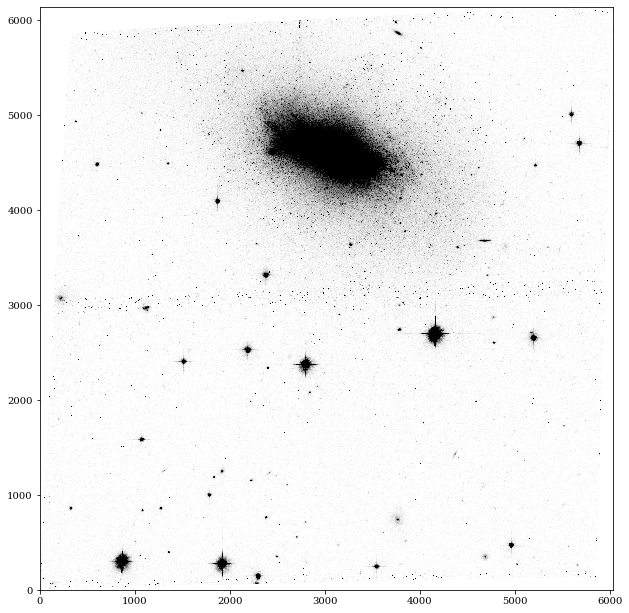

In [12]:
# Display the image 

if 'fig1' in locals() or 'fig1' in globals(): plt.close(fig1)
fig1 = plt.figure(1,figsize=(9,9))
# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig1)

fig1_ax1 = fig1.add_axes([.05,.05,.9,.9]) #,projection=wcs)

fig1_ax1.imshow(data, origin = 'lower', vmin=-0., vmax = data.mean()*5, cmap = 'Greys')

if 'stars_tbl' in locals() or 'stars_tbl' in globals():
    fig1_ax1.plot(stars_tbl['xcentroid'],stars_tbl['ycentroid'],'o',alpha=0.25, color='cyan')
    fig1_ax1.plot(temp_tbl['xcentroid'],temp_tbl['ycentroid'],'o',alpha=0.25, color='red')

In [4]:
# Find stars in the image

from photutils.detection import DAOStarFinder

# On the HLA image
dao_find = DAOStarFinder(threshold=50, fwhm=2.0, peakmax=9e4, sigma_radius=6, exclude_border=True, sharplo=0.6, sharphi=1.05, roundlo=-.1, roundhi=0.2) #, brightest=250)

# On the astrodrizzled
dao_find = DAOStarFinder(threshold=90, fwhm=2.2, peakmax=8e4, sigma_radius=7, exclude_border=True, sharplo=0.6, sharphi=1.1, roundlo=-.2, roundhi=0.25) #, brightest=250)

# On the astrodrizzled with tinytim PSFs
dao_find = DAOStarFinder(threshold=90, fwhm=2.8, peakmax=8e4, sigma_radius=5, exclude_border=True, sharplo=0.5, sharphi=1.1, roundlo=-.3, roundhi=0.3) #, brightest=250)


In [5]:
stars_tbl = dao_find(data)
print('Found {:} stars'.format(len(stars_tbl['id'])))
stars_tbl.sort('mag')

Found 5149 stars


In [6]:
stars_tbl.columns

<TableColumns names=('id','xcentroid','ycentroid','sharpness','roundness1','roundness2','npix','sky','peak','flux','mag')>

In [7]:
# Visualize in the above plot (in interactive only) the preselected stars

# Explicitly exclude stars that are too close to the image boundaries, because they cannot be extracted.

size = 50
hsize = (size - 1) / 2
x = stars_tbl['xcentroid']  
y = stars_tbl['ycentroid']  

# Filter by property
xcen=3800 ; ycen=2300
xcen=3100 ; ycen=4700
excl_radius = 1500

round1=.3; round2=.3; sharp=0.7; mag_faint_inst = -2.0

mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) & \
        (y > hsize) & (y < (data.shape[0] -1 - hsize)) & \
        (np.sqrt((x-xcen)**2 + (y-ycen)**2)>=excl_radius) & \
        (stars_tbl['mag']<=mag_faint_inst) & \
        (stars_tbl['sharpness']>=sharp) & \
        (abs(stars_tbl['roundness1'])<=round1) & \
        (abs(stars_tbl['roundness2'])<=round2))
    
temp_tbl = stars_tbl[mask].copy()

print('Selected {:} stars out of {:} initially detected'.format(len(temp_tbl['id']),len(stars_tbl['id'])))

fig1_ax1.plot(stars_tbl['xcentroid'],stars_tbl['ycentroid'],'o',alpha=0.25, color='cyan')
fig1_ax1.plot(temp_tbl['xcentroid'],temp_tbl['ycentroid'],'o',alpha=0.25, color='red')

Selected 341 stars out of 5149 initially detected


/Users/georgiev/Installs/miniconda3/lib/python3.6/site-packages/astropy/table/column.py:1020: RuntimeWarning: invalid value encountered in less_equal
  result = getattr(super(), op)(other)


N good stars: 63
N bad: 0
Total 63


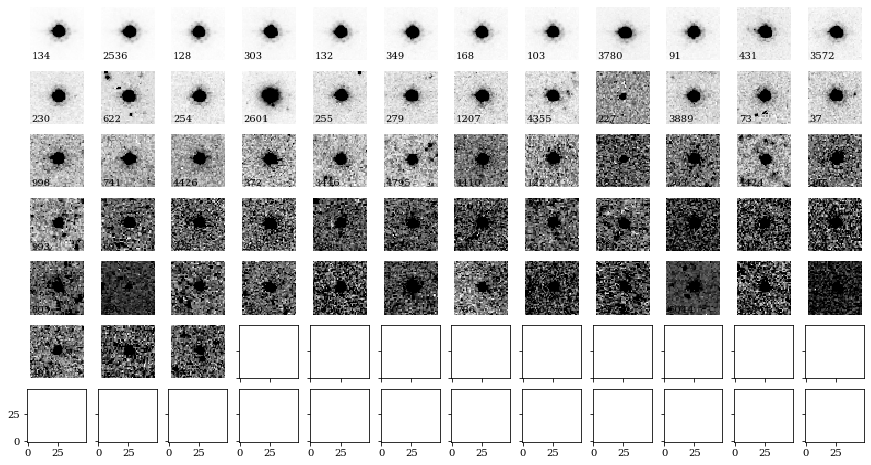

In [50]:
# Selecting EPSFStars, from which we’ll build our ePSF
from astropy.stats import sigma_clipped_stats

# Choose which stars to treat as good, if the sigma clipped stats of the star box are within mean_median_factor. Large factor does not exclude stars, e.g. 1e3.
# 
mean_median_factor = 1.3e3 # 1e3 # 

i=0
good_list_count = []
good_list = []
bad_list = []
# Needed in order to locate the index of a column
temp_tbl.add_index('id')

for epsf_star in temp_tbl:
    epsf_star_data = data[int(epsf_star['ycentroid']-hsize):int(epsf_star['ycentroid']+hsize),int(epsf_star['xcentroid']-hsize):int(epsf_star['xcentroid']+hsize)].copy()
    mean, median, std = sigma_clipped_stats(epsf_star_data, sigma=3.0)
    if std <= mean*mean_median_factor and std <= median*mean_median_factor:
        #print(epsf_star.id_label, mean, median, std,epsf_star.data.min())
        good_list_count.append(i)
        good_list.append(int(epsf_star['id']))
#        print(epsf_star['id'],median,epsf_star_data.min())
    else:
        bad_list.append(epsf_star['id'])
#        print(epsf_star['id'], end=', ')
#        temp_tbl.remove_row(temp_tbl.loc[int(epsf_star['id'])].index)
    i+=1
print('N good stars: {:}\nN bad: {:}\nTotal {:}'.format(len(good_list),len(bad_list),len(temp_tbl['id'])))

#from astropy.visualization import simple_norm
ncols = 12
if round(len(good_list_count)/ncols)<=2 :
    nrows = round(len(good_list_count)/ncols)
else:
    nrows = 7

#nrows = 5
if 'fig3' in globals(): plt.close(fig=fig3)
fig3, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True,figsize=(15,8),sharex=True, sharey=True)
fix_canvas(fig3)

good_list_upd = []
ax = ax.ravel()
for i,epsf_star in zip(range(len(temp_tbl['id'])),range(len(temp_tbl['id']))):
    epsf_star = temp_tbl[epsf_star]
    epsf_star_data = data[int(epsf_star['ycentroid']-hsize):int(epsf_star['ycentroid']+hsize),int(epsf_star['xcentroid']-hsize):int(epsf_star['xcentroid']+hsize)].copy()
    ax[i].imshow(epsf_star_data, vmin=epsf_star_data.min(), vmax=epsf_star_data.mean()*2, origin='lower', cmap='Greys') # norm=norm, 
    ax[i].text(1,1,'{:}'.format(epsf_star['id']))
    ax[i].axis('off')
    if int(epsf_star['id']) is not None:
        good_list_upd.append(int(epsf_star['id']))


In [ ]:
# Save figure

In [48]:
print(good_list_upd[:12], end=' '),print('\n', end=' ')
print(good_list_upd[12:24], end=' '),print('\n', end=' ')
print(good_list_upd[24:36], end=' '),print('\n', end=' ')
print(good_list_upd[36:48], end=' '),print('\n', end=' ')
print(good_list_upd[48:60], end=' '),print('\n', end=' ')
print(good_list_upd[60:72], end=' '),print('\n', end=' ')
print(good_list_upd[72:84], end=' '),print('\n', end=' ')

[134, 2536, 128, 303, 132, 349, 168, 103, 3780, 91, 431, 3572] 
 [230, 622, 254, 2601, 255, 279, 1207, 4355, 227, 3889, 73, 37] 
 [998, 741, 4426, 372, 3446, 4795, 4410, 122, 182, 263, 4424, 346] 
 [993, 697, 228, 266, 588, 1661, 246, 451, 911, 381, 143, 167] 
 [505, 486, 561, 760, 5026, 60, 786, 100, 736, 437, 634, 5044] 
 [438, 902, 5116, 4830, 459, 481, 68, 727, 512, 98, 815, 520] 
 [288, 472, 415] 
 

(None, None)

In [ ]:
# good_list_upd = [1960, 135, 44, 339, 143, 166, 367, 112, 2784, 96, 417, 2637, 219, 160, 916, 588, 41, 252, 253, 281, 66, 1075, 3201, 2861, 43, 284, 3822, 107, 905, 3261, 1706, 3469, 359, 3827, 3711, 2537, 13, 3530, 684, 3249, 130, 5, 739, 3259, 336, 3552, 268, 211, 774, 900, 646, 173, 228, 243, 560, 87, 165, 152, 362, 3467, 3717, 726, 3299, 104, 820, 1375, 424]

In [49]:
# Manually remove bad stars from the list above and re run the plot
# 

bad_list = [736, 634,5116,459, 481, 68, 727, 512, 98, 815,288, 415]

for star_id in bad_list:
    temp_tbl.remove_row(temp_tbl.loc[star_id].index) 


In [ ]:

# Background image subtraction can be also done with a smooth large aperture median filetring and subtraction


In [14]:
# The star cutouts from which we build the ePSF must be background subtracted. 

from astropy.stats import sigma_clipped_stats
from photutils import make_source_mask
from photutils import Background2D, MedianBackground

print('Calculating sigma clipped stats for source detection and masking')
mask = make_source_mask(data, nsigma=3, npixels=3, dilate_size=11,)
mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)

print((mean, median, std)) 
# Additional mask if needed
# mask = (data == 0)

Calculating sigma clipped stats for source detection and masking
(1.8529123, 1.5399457, 6.6713195)


In [15]:
# Execute this only once per session.

print('Calculating 2D background estimate on a smoothed and subgrided sections of the image')
bkg = Background2D(data, (55, 55), filter_size=(3, 3)) #, mask=mask)

# Applying the mask to the returned background image
bkg_img = bkg.background * ~mask

Calculating 2D background estimate on a smoothed and subgrided sections of the image


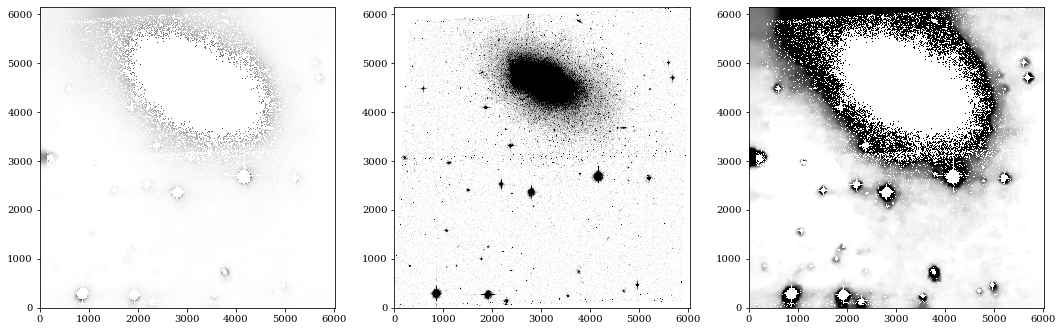

In [17]:
# (OPTIONAL) Display the background and the residual

if 'fig2' in globals() or 'fig2' in locals(): plt.close(fig2)
fig2 = plt.figure(2,figsize=(3*6,6))
# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig2)

fig2_ax1 = fig2.add_subplot(1,3,1) #, position=[.0,.1,.9,.9]) #,projection=wcs)
fig2_ax2 = fig2.add_subplot(1,3,2) #, position=[.25,.1,.9,.9]) #,projection=wcs)
fig2_ax3 = fig2.add_subplot(1,3,3) #, position=[.25,.1,.9,.9]) #,projection=wcs)

fig2_ax1.imshow(bkg_img, origin = 'lower', vmin=-0, vmax = bkg_img.max(), cmap = 'Greys')
fig2_ax2.imshow(data - bkg_img, origin = 'lower', vmin=-0, vmax = (data - bkg_img).mean()*3, cmap = 'Greys')
fig2_ax3.imshow(bkg_img, origin = 'lower', vmin=-0, vmax = bkg_img.mean()*3, cmap = 'Greys')

# Overplot the preselected PSF stars
if 'temp_tbl' in globals():
    fig2_ax2.plot(temp_tbl['xcentroid'],temp_tbl['ycentroid'],'o',alpha=0.25, color='blue')

In [54]:
# Extracting the stars requires that the input table has column names x,y for the star's positions
# We're also saving the ePSF stars to a file

ePSF_stars_tbl = temp_tbl.copy()
ePSF_stars_tbl.rename_columns(['xcentroid', 'ycentroid'], ['x','y'])
#ePSF_stars_tbl.write('{:}_ePSF_stars.dat'.format(filename), format='ascii', overwrite=True)

In [55]:
# The extract_stars() function requires the input data as an NDData object. 
from astropy.nddata import NDData
nddata = NDData(data=(data-bkg_img))

# Extract the pixel cutouts of the selected stars:

from photutils.psf import extract_stars
ePSF_stars = extract_stars(nddata, ePSF_stars_tbl, size=50)


In [173]:
from photutils import EPSFBuilder,EPSFFitter
from photutils import centroids
from astropy.modeling.fitting import SLSQPLSQFitter,SimplexLSQFitter

#centroids.centroid_1dg # Calculate the centroid of a 2D array by fitting 1D Gaussians to the marginal x and y distributions of the array.
#centroids.centroid_2dg # Calculate the centroid of a 2D array by fitting a 2D Gaussian (plus a constant) to the array.
#centroids.centroid_com # Calculate the centroid of an n-dimensional array as its “center of mass” determined from moments.
#centroids.centroid_epsf # Calculates centering shift of data using pixel symmetry, as described by Anderson and King (2000; PASP 112, 1360) in their ePSF-fitting algorithm.
#centroids.centroid_sources # Calculate the centroid of sources at the defined positions.
#centroids.fit_2dgaussian # Fit a 2D Gaussian plus a constant to a 2D image.
#centroids.gaussian1d_moments # Estimate 1D Gaussian parameters from the moments of 1D data.

new_fitter = EPSFFitter(fit_boxsize=12.5) #,fitter=SLSQPLSQFitter())

epsf_builder = EPSFBuilder(oversampling=2, maxiters=2, recentering_maxiters=15, recentering_func=centroids.centroid_com, \
                           shift_val=0.1, fitter=new_fitter, progress_bar=True,smoothing_kernel='quartic', norm_radius=44.5,\
                           recentering_boxsize=(2.5, 2.5))

# Modify the clipping values
epsf_builder.sigma=4.0
epsf_builder.sigma_lower=4.
epsf_builder.sigma_upper=4.

epsf, fitted_stars = epsf_builder(ePSF_stars)
epsf.data.max()

0.06681349036619338

In [174]:
from astropy.modeling import models, fitting

epsf_x,epsf_y=np.mgrid[:np.shape(epsf.data)[0],:np.shape(epsf.data)[1]]

g_init = models.Gaussian2D(amplitude=epsf.data.max(),x_mean=epsf.x_origin,y_mean=epsf.y_origin,x_stddev=3.,y_stddev=7., theta=0.50)
fit_g = fitting.LevMarLSQFitter()
g2d = fit_g(g_init, x=epsf_x, y=epsf_y, z=epsf.data)

mof_init = models.Moffat2D(amplitude=epsf.data.max(),x_0=epsf.x_origin,y_0=epsf.y_origin,alpha=3.,gamma=-4.) #,bounds={'gamma': (-10,10)})
fit_mof = fitting.LevMarLSQFitter()
mof2d = fit_mof(mof_init, x=epsf_x, y=epsf_y, z=epsf.data)

# Composite
g_m_init = models.Gaussian2D(amplitude=g2d.amplitude.value/5,x_mean=g2d.x_mean.value,y_mean=g2d.y_mean.value,x_stddev=g2d.x_stddev.value,\
                             y_stddev=g2d.y_stddev.value, theta=g2d.theta.value) + \
models.Moffat2D(amplitude=mof2d.amplitude.value/1.,x_0=mof2d.x_0.value,y_0=mof2d.y_0.value,alpha=mof2d.alpha.value,gamma=mof2d.gamma.value)

fit_g_m = fitting.LevMarLSQFitter()
g_m_2d = fit_g_m(g_m_init, x=epsf_x, y=epsf_y, z=epsf.data)

In [175]:
g2d,mof2d,g_m_2d

(<Gaussian2D(amplitude=0.06314697, x_mean=54.98413164, y_mean=55.16476139, x_stddev=2.50460375, y_stddev=2.58406705, theta=-13.05243824)>,
 <Moffat2D(amplitude=0.04874173, x_0=54.99332022, y_0=55.20681043, gamma=-13.96597068, alpha=11.38052888)>,
 <CompoundModel(amplitude_0=0.0423725, x_mean_0=54.98231281, y_mean_0=55.00066848, x_stddev_0=1.63027955, y_stddev_0=1.7491489, theta_0=-13.70618306, amplitude_1=0.02925648, x_0_1=55.017729, y_0_1=55.47744792, gamma_1=-13.70718279, alpha_1=8.34342788)>)

(-5.1000000000000005, 107.1, -5.1000000000000005, 107.1)

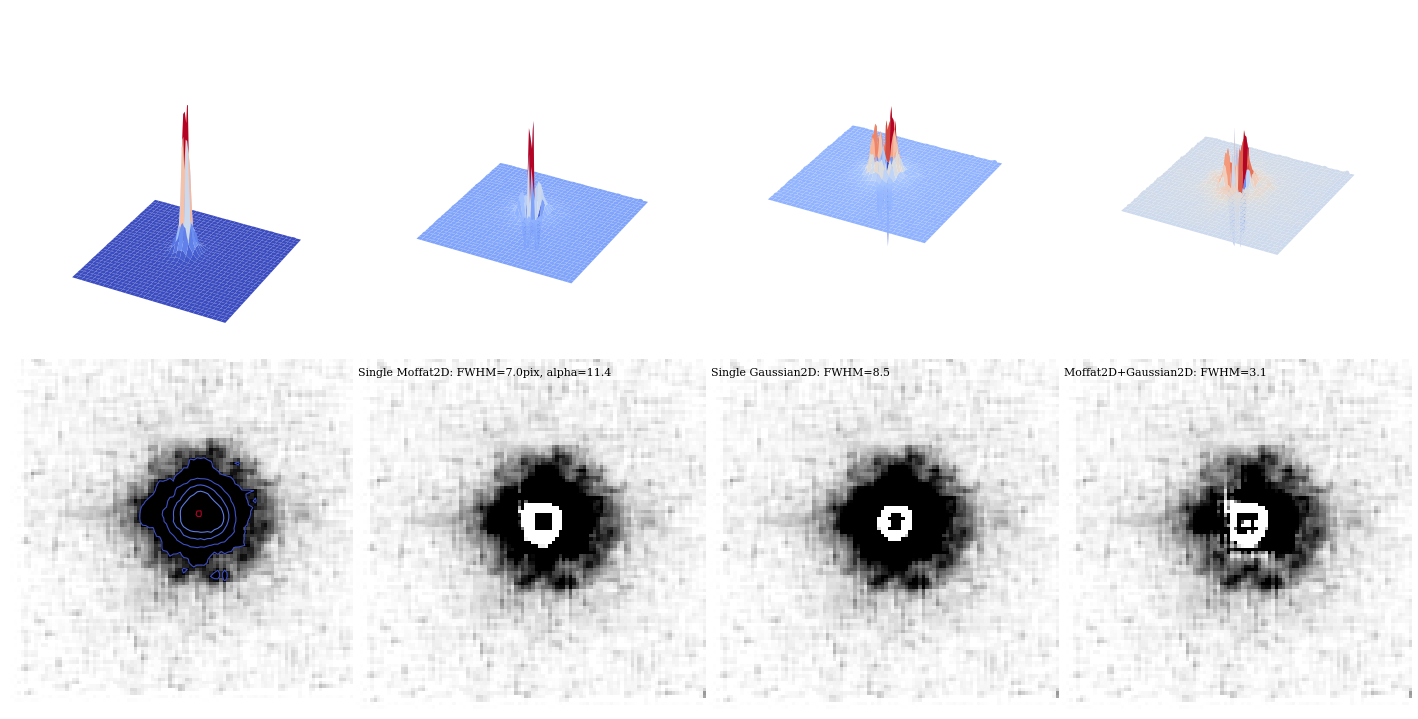

In [176]:
# Create a mesh plot from a selected region around the target

# Needed for the 3D mesh plot
from mpl_toolkits.mplot3d import Axes3D

# Create the meshgrid in x,y needed for the 3D
ny , nx = epsf.data.shape
x = np.arange(0,nx,1)
y = np.arange(0,ny,1)
xv, yv = np.meshgrid(x,y)

if 'fig4' in locals() or 'fig4' in globals(): plt.close(fig4)
fig4 = plt.figure(4,figsize=(9.8,9.8))

# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig4)

#fig4_ax = fig4.add_axes([.05,.05,.9,.9])
fig4_ax1 = fig4.add_subplot(4,2,1, position=[.01,.01,.5,.5])
fig4_ax2 = fig4.add_subplot(4,2,2, projection='3d', position=[.01,.5,.5,.5])
fig4_ax3 = fig4.add_subplot(4,2,3, projection='3d', position=[.5,.5,.5,.5])
fig4_ax4 = fig4.add_subplot(4,2,4, position=[.5,.0,.5,.5])
fig4_ax5 = fig4.add_subplot(4,2,5, position=[1.0,.0,.5,.5])
fig4_ax6 = fig4.add_subplot(4,2,6, projection='3d', position=[1.0,.5,.5,.5])
fig4_ax7 = fig4.add_subplot(4,2,7, position=[1.5,.0,.5,.5])
fig4_ax8 = fig4.add_subplot(4,2,8, projection='3d', position=[1.5,.5,.5,.5])

fig4_ax1.imshow(epsf.data, origin='lower',vmin=-0,vmax=epsf.data.mean(), cmap='Greys')
fig4_ax1.contour(epsf.data, levels=[epsf.data.mean()*1.,epsf.data.mean()*3.5,epsf.data.mean()*10,epsf.data.mean()*20,epsf.data.max()*.95], linewidths=1.1, cmap='coolwarm')
fig4_ax1.axis('off')

fig4_ax2.plot_surface(xv,yv,epsf.data, cmap='coolwarm',rcount=50,ccount=50)
fig4_ax2.view_init(elev=30, azim=208)
#fig4_ax2.contour(xv,yv,epsf.data, zdir='z', offset=epsf.data.max()*1.2, \
#                 levels=[epsf.data.mean()*2.,epsf.data.mean()*3.5,epsf.data.mean()*10,epsf.data.mean()*20,epsf.data.mean()*50,epsf.data.max()*.95], \
#                 cmap='coolwarm')
fig4_ax2.axis('off')

fig4_ax3.plot_surface(xv,yv,epsf.data-mof2d(epsf_x,epsf_y), cmap='coolwarm',rcount=50,ccount=50)
fig4_ax3.view_init(elev=30, azim=208)
#fig4_ax3.contour(xv,yv,epsf.data-mof2d(epsf_x,epsf_y), zdir='z', offset=(epsf.data-mof2d(epsf_x,epsf_y)).min()*1.2, \
#                 levels=[epsf.data.mean()*2.0,epsf.data.mean()*3.5,epsf.data.mean()*10,epsf.data.mean()*20,epsf.data.mean()*50,epsf.data.max()*.95], \
#                 cmap='coolwarm')
fig4_ax3.axis('off')

#fig4_ax3.imshow(epsf.data-g2d(epsf_x,epsf_y), origin='lower',vmin=0,vmax=(epsf.data-g2d(epsf_x,epsf_y)).mean()*5, cmap='Greys',\
#                label='Gaussian fit: $\sigma_x$={:.1f}, $\sigma_y$={:.1f}'.format(g2d.x_stddev.value, g2d.y_stddev.value))
fig4_ax4.imshow(epsf.data-mof2d(epsf_x,epsf_y), origin='lower',vmin=-0,vmax=epsf.data.mean(), cmap='Greys')
fig4_ax4.text(1,epsf.data.shape[0]*.95,'Single Moffat2D: FWHM={:.1f}pix, alpha={:.1f}'.format(mof2d.fwhm,mof2d.alpha.value),size=11)
fig4_ax4.axis('off')

fig4_ax5.imshow(epsf.data-g2d(epsf_x,epsf_y), origin='lower',vmin=-0,vmax=epsf.data.mean(), cmap='Greys')
fig4_ax5.text(1,epsf.data.shape[0]*.95,'Single Gaussian2D: FWHM={:.1f}'.format(np.sqrt(g2d.x_fwhm**2+g2d.y_fwhm**2)),size=11)
fig4_ax5.axis('off')

fig4_ax6.plot_surface(xv,yv,epsf.data-g2d(epsf_x,epsf_y), cmap='coolwarm',rcount=50,ccount=50)
fig4_ax6.view_init(elev=30, azim=208)
fig4_ax6.axis('off')

fig4_ax7.imshow(epsf.data-g_m_2d(epsf_x,epsf_y), origin='lower',vmin=-0,vmax=epsf.data.mean(), cmap='Greys')
fig4_ax7.text(1,epsf.data.shape[0]*.95,'Moffat2D+Gaussian2D: FWHM={:.1f}'.format(np.sqrt(g_m_2d.x_stddev_0**2+g2d.y_stddev**2)),size=11)
fig4_ax7.axis('off')

fig4_ax8.plot_surface(xv,yv,epsf.data-g_m_2d(epsf_x,epsf_y), cmap='coolwarm',rcount=50,ccount=50)
fig4_ax8.view_init(elev=30, azim=208)
fig4_ax8.axis('off')

In [159]:
# (Optional) Save the figure 
fig_file_name = '{:s}_ePSFx{:}.pdf'.format(filename,epsf_builder.oversampling[0])
fig4.savefig(fig_file_name,\
            format='pdf',transparent=True,dpi=120,bbox_inches='tight')
print('Saved figure {:s}'.format(fig_file_name))
os.system('pdfcrop {:} {:}'.format(fig_file_name,fig_file_name))
os.system('open {:}'.format(fig_file_name))

Saved figure NGC-2337_ACS_WFC_F814W_adrz_ePSF.pdf


0

In [179]:
# Save the ePSF as a fits file

ePSF_file_name = '{:s}_ePSFx{:}.fits'.format(filename,epsf_builder.oversampling[0])

fits.writeto(ePSF_file_name,data=epsf.data,overwrite=True)

In [161]:
# Store information in the header about the ePSF builder parameters used to generate the ePSF

#i=0
with fits.open(ePSF_file_name, 'update') as f:
    for hdu in f:
        hdu.header['Comment'] = 'ePSF for {:}'.format(filename)
        hdu.header['Comment'] = 'epsf_builder parameters:'
        for param in epsf_builder.__dict__:
            line1 = str(param).strip('_,:,>,<')
            line2 = str(epsf_builder.__dict__[param]).strip(r'],[_,:,>,<,\n')
#            print(line1,line2.split())
            hdu.header['Comment']=('{:} / {:}'.format(line1,line2.split()))
#        for star_xy in fitted_stars.center_flat:
#            hdu.header['Star{:}'.format(i)]=('{:}'.format(str(star_xy)),'epsf_builder star')
#            i+=1

In [162]:
# (Optional) Have a look at the header

print(repr(fits.getheader(ePSF_file_name)))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  103                                                  
NAXIS2  =                  103                                                  
EXTEND  =                    T                                                  
COMMENT ePSF for NGC-2337_ACS_WFC_F814W_adrz                                    
COMMENT epsf_builder parameters:                                                
COMMENT norm_radius / ['44.5']                                                  
COMMENT shift_val / ['0.1']                                                     
COMMENT oversampling / ['2', '2']                                               
COMMENT shape / ['None']                                                        
COMMENT recentering_func / [

# Perform basic PSF fitting photometry on the ePSF stars

In [163]:
from photutils.psf import (IterativelySubtractedPSFPhotometry,
                           BasicPSFPhotometry)
from photutils import MMMBackground
from photutils.psf import IntegratedGaussianPRF, DAOGroup
#from photutils.detection import DAOStarFinder
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter



daogroup = DAOGroup(crit_separation=8)
mmm_bkg = MMMBackground()

fitter = LevMarLSQFitter()
#gaussian_prf = IntegratedGaussianPRF(sigma=1.95)
#gaussian_prf.sigma.fixed = False
ePSF_model = epsf
#itr_phot_obj = IterativelySubtractedPSFPhotometry(aperture_radius=5,
#                                                  finder=dao_find,
#                                                  group_maker=daogroup,
#                                                  bkg_estimator=mmm_bkg,
#                                                  psf_model=ePSF_model,
#                                                  fitter=fitter,
#                                                  fitshape=(11, 11),
#                                                  niters=2)

phot_obj = BasicPSFPhotometry(aperture_radius=5,
                              finder=None,
                              group_maker=daogroup,
                              bkg_estimator=mmm_bkg,
                              psf_model=ePSF_model,
                              fitter=fitter,
                              fitshape=(25, 25))

In [164]:
# Performing PSF photometry on a specific list of objects from a table, requires a bit table modification.
# It must contain sequenced stellar IDs and column names x_0,y_0

# Use the ePSF_stars_tbl 

phot_obj_tbl = Table(ePSF_stars_tbl,copy=True,copy_indices=False)
phot_obj_tbl.rename_columns(['x', 'y'], ['x_0','y_0'])

for i in range(1,len(phot_obj_tbl['id'])+1):
    phot_obj_tbl['id'][i-1]=i


In [165]:
# BasicPSFPhotometry on the list of ePSF stars

# Uncomment the lines below to use the DAOStarFinder table as an input
#
#phot_obj_tbl = stars_tbl.copy()
#if 'x_0' not in phot_obj_tbl.colnames and 'y_0' not in phot_obj_tbl.colnames :
#    phot_obj_tbl.rename_columns(['xcentroid', 'ycentroid'], ['x_0','y_0'])

phot_results = phot_obj(data,init_guesses=phot_obj_tbl)

In [166]:
phot_results.columns
#itr_phot_results.columns

<TableColumns names=('id','x_0','y_0','sharpness','roundness1','roundness2','npix','sky','peak','flux','mag','flux_0','group_id','x_fit','y_fit','flux_fit','flux_unc','x_0_unc','y_0_unc')>

In [167]:
#phot_results.columns
phot_results_rsd_img = phot_obj.get_residual_image()

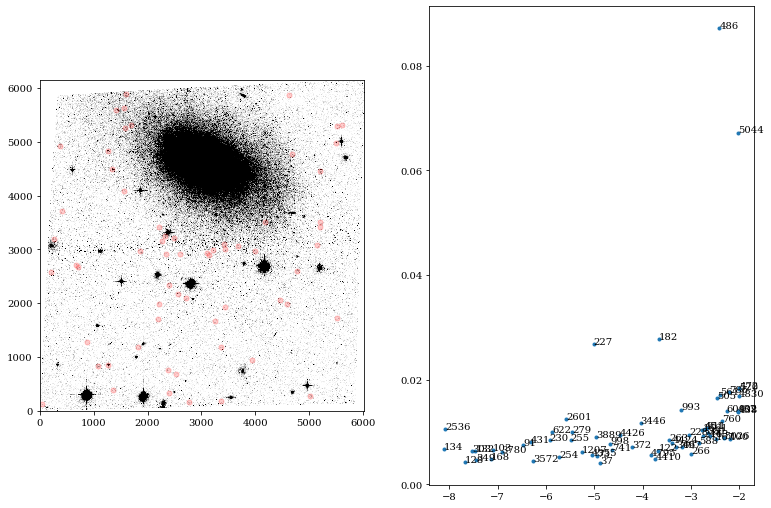

In [168]:
# Have a look at the residuals

if 'fig5' in locals() or 'fig5' in globals(): plt.close(fig5)
fig5 = plt.figure(5,figsize=(12.8,8.8))

# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig5)

fig5_ax1 = fig5.add_subplot(121)
fig5_ax2 = fig5.add_subplot(122)

fig5_ax1.imshow(phot_results_rsd_img, origin='lower', cmap='Greys', vmin=phot_results_rsd_img.mean()*.05, vmax=phot_results_rsd_img.mean()*1.5)
fig5_ax1.plot(phot_results['x_fit'],phot_results['y_fit'],'o',ms=5,color='red', alpha=.2)

selection = (phot_results['x_0']==stars_tbl['xcentroid']) & (phot_results['y_0']==stars_tbl['ycentroid'])
#selection = (phot_results['x_fitt']==ePSF_stars_tbl['x']) & (phot_results['y_fit']==ePSF_stars_tbl['y'])
fig5_ax2.plot(phot_results['mag'],2.5*phot_results['flux_unc']/(np.log(10)*(phot_results['flux_fit'])),'.')
for x_text,y_text,label_text in zip(phot_results['mag'],\
                                    2.5*phot_results['flux_unc']/(np.log(10)*(phot_results['flux_fit'])),\
                                    temp_tbl['id'][phot_results['x_0']==temp_tbl['xcentroid']]):
    fig5_ax2.text(x_text,y_text,label_text)
#fig5_ax2.imshow(itr_phot_result_rsd_img, origin='lower', cmap='Greys')


ID	Median	std	Min	Max


/Users/georgiev/Installs/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


134	-63.95	1255.39	-13035.87	15670.54
2536	-36.74	1783.98	-17947.32	23899.28
128	-44.83	496.45	-5456.27	6034.00
303	-25.24	666.69	-6831.79	6053.49
132	-29.62	628.30	-8043.13	8310.59
349	-30.00	458.24	-6908.85	4874.88
168	-26.92	352.27	-5652.93	3579.02
103	-28.01	444.79	-3870.45	5415.64
3780	-17.49	383.88	-2166.65	5004.72
91	-9.67	294.22	-3872.59	3932.76
431	-6.40	272.94	-3292.79	3976.70
3572	-6.42	140.54	-1521.06	1460.99
230	-9.97	203.94	-2938.32	2470.41
622	-1.46	225.92	-2329.93	3036.53
254	-6.66	103.12	-1101.48	1056.29
2601	57.15	219.66	-2296.57	1141.48
255	-7.69	135.12	-1674.65	1923.35
279	-5.07	149.87	-1640.27	2136.98
1207	-1.15	79.81	-817.52	907.02
4355	5.32	61.31	-743.71	485.94
227	-16.30	256.80	-1706.92	3672.62
3889	-2.25	91.54	-1169.53	677.38
73	-4.79	48.53	-418.07	527.39
37	-3.80	36.24	-410.21	381.91
998	-2.60	56.13	-604.60	580.72
741	1.02	46.59	-525.38	459.92
4426	-1.79	55.52	-547.62	677.27
372	-2.37	35.04	-255.79	507.42
3446	5.84	48.37	-432.23	549.86
4795	6.69	18.06	-127.33	

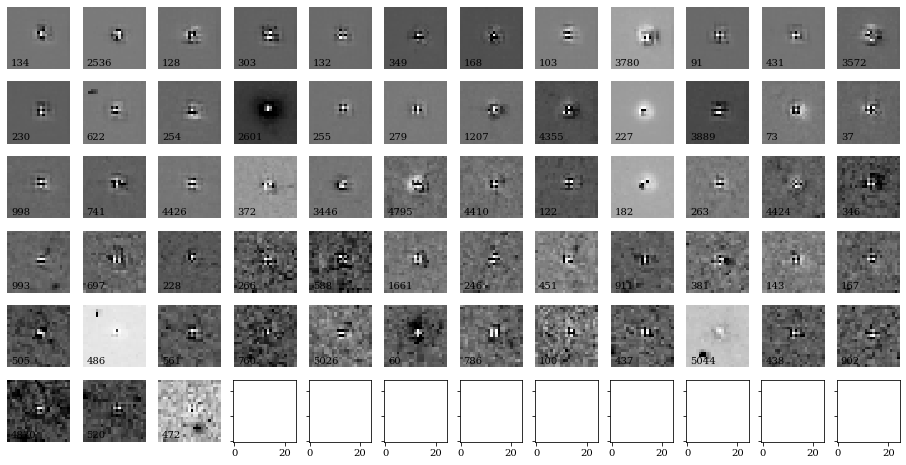

In [169]:
# 
width = 25
ncols = 12
if round(len(good_list_count)/ncols)<=2 :
    nrows = round(len(good_list_count)/ncols)
else:
    nrows = 6

if 'fig6' in globals(): plt.close(fig=fig6)
fig6, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True,figsize=(16,8),sharex=True, sharey=True)
fix_canvas(fig6)

ax = ax.ravel()
print('ID\tMedian\tstd\tMin\tMax')
for i,epsf_star in zip(range(len(good_list_count)),range(len(ePSF_stars_tbl['id']))):
    epsf_star = ePSF_stars_tbl[epsf_star]
    epsf_star_data = phot_results_rsd_img[int(epsf_star['y']-width/2):int(epsf_star['y']+width/2),int(epsf_star['x']-width/2):int(epsf_star['x']+width/2)].copy()
    ax[i].imshow(epsf_star_data, vmin=epsf_star_data.min(), vmax=epsf_star_data.max()*.5, origin='lower', cmap='Greys') # norm=norm, 
    ax[i].text(1,1,'{:}'.format(epsf_star['id']))
    ax[i].axis('off')
    print('{:}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(epsf_star['id'],np.median(epsf_star_data),epsf_star_data.std(),epsf_star_data.min(),epsf_star_data.max()))


In [170]:
# Based on the residuals above, one can further remove sources that show strong, non stellar like residuals or have contaminants
# Then rerun 


In [1]:
print(good_list_upd, end=' ')

NameError: name 'good_list_upd' is not defined

In [172]:
#temp_tbl[temp_tbl['id']==339]
phot_results[(phot_results['x_0']==temp_tbl['xcentroid'][temp_tbl['id']==2601]) | (phot_results['x_0']==temp_tbl['xcentroid'][temp_tbl['id']==60])]

id,x_0,y_0,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,flux_0,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
16,1347.8948813637403,4485.349985587653,0.7153716903078713,-0.057424809176406105,-0.053723054349121224,121,0.0,7138.736328125,170.91166082990708,-5.58192923610728,149024.08408424168,16,1345.8568107825904,4483.502399357343,152652.04809969632,1754.1460049592272,0.017750040021321453,0.01994912478655394
54,2772.1245597960815,163.16970924030974,0.8612232673279483,-0.03326776789910194,0.16472963671947158,121,0.0,387.43218994140625,8.026327068046081,-2.261292132499496,6770.7745800809735,54,2770.039938641438,161.1864967988654,6965.5904937186615,89.95800865480386,0.020566261324762535,0.020595006752565252
